In [20]:
import sys
sys.path.append('/home/emastr/phd/')
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

### Defining a boundary using gradient flow
One way to randomly deform a boundary is to use a potential field that continuously deforms the boundary points.

## Generate random walks

(690, 2) (1, 2)
(236, 2) (1, 2)
(218, 2) (1, 2)
(406, 2) (1, 2)
(412, 2) (1, 2)
(202, 2) (1, 2)
(276, 2) (1, 2)
(370, 2) (1, 2)
(272, 2) (1, 2)


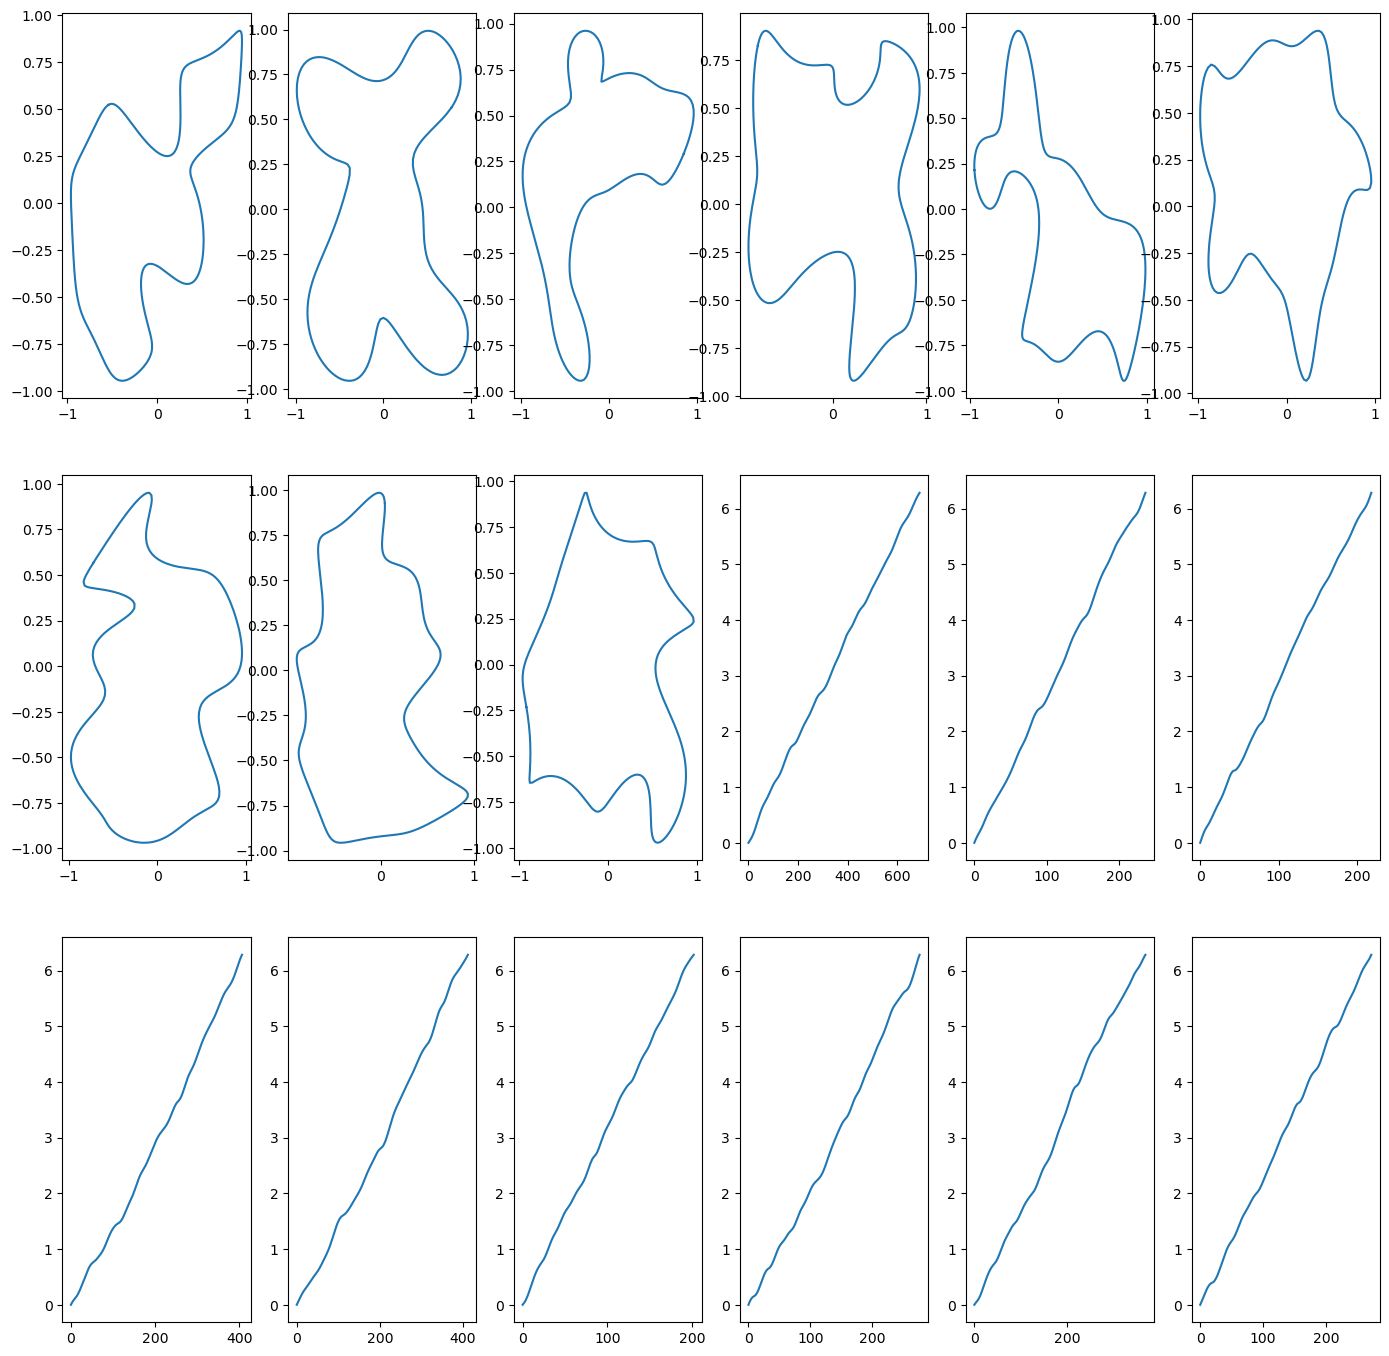

In [27]:

np.random.seed(0)
def reparameterize_data(t, data, k_max=None):
    """Reparameterize the data to be a function of t in [0,2pi]."""
    f = interp1d(t, data, axis=-1)
    t = np.linspace(0, 2*np.pi, data.shape[1]+1)[:-1]
    data = f(t)
    
    return data

def loop_erased_rw():
    N = 100
    Nmax = 200

    x,y = [0],[0]
    steps = [(0,1),(0,-1),(-1,0),(1,0)]


    for n in range(100000):
        step_idx = np.random.randint(0,4)
        dx,dy = steps[step_idx]
        xn = x[-1]+dx
        yn = y[-1]+dy

        intersects = [i for i in range(len(y)-1) if x[i]==xn and y[i]==yn]
        assert len(intersects) <= 1, "Something is wrong"

        if len(intersects) == 0:
            x.append(xn)
            y.append(yn)

        elif len(intersects) == 1:
            i = intersects[0]
            if (len(x) - i) >= Nmax:
                x = x[i:]
                y = y[i:]
                break
            else:
                x = x[:i+1]
                y = y[:i+1]        


    # Define numpy arrays
    x = np.array(x)
    y = np.array(y)
    # Center
    x = 2*(x-(min(x)+max(x))/2)/(max(x)-min(x))
    y = 2*(y-(min(y)+max(y))/2)/(max(y)-min(y))
    t = np.linspace(0,2*np.pi,len(x))
    #X,Y
    K = 10
    ks = np.arange(-K, K)

    E = np.exp(1j * ks[None, :] * t[:, None])
    c = np.linalg.solve(np.conjugate(E.T) @ E, np.conjugate(E.T) @ np.hstack([x[:,None], y[:,None]]))
    
    xy = np.real(E @ c)
    xy_der = np.real( E @ (1j * ks[:, None] * c))
    dxy = np.sqrt(xy_der[:, 0]**2 + xy_der[:, 1]**2)
    arclength = np.cumsum(dxy)
    arclength = np.concatenate([[0], arclength])/arclength[-1] * 2 * np.pi
    
    print(xy.shape, xy[0:1,:].shape)
    xycat = np.vstack([xy, xy[0:1,:]])
    xy = reparameterize_data(arclength, xycat.T)
    xy = xy.T
    return c, x, y, xy, arclength


M = 3
plt.figure(figsize=(17,17))
pts = []
for i in range(M*M):
    plt.subplot(M,2*M,i+1)
    c,x,y,xy,l = loop_erased_rw()
    pts.append(xy)
    plt.plot(xy[:,0], xy[:, 1])
    plt.subplot(M,2*M,M*M+i+1)
    plt.plot(l)